In [1]:
## output bikeshare density for what area could support
## output bikeability based on strava data to decide if area is a good idea
## Assumes that bike shares are optimally placed and near optimal capacity
## use regularization in the training of the ML model

import pandas as pd
import pandas_profiling
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import nearest_points
import branca.colormap as cm


from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Workaround to fix chrome issue where folium won't plot maps with a large number of layers
# See comment by dstein64 at: https://github.com/python-visualization/folium/issues/812

import base64
def _repr_html_(self, **kwargs):
    html = base64.b64encode(self.render(**kwargs).encode('utf8')).decode('utf8')
    onload = (
        'this.contentDocument.open();'
        'this.contentDocument.write(atob(this.getAttribute(\'data-html\')));'
        'this.contentDocument.close();'
    )
    if self.height is None:
        iframe = (
            '<div style="width:{width};">'
            '<div style="position:relative;width:100%;height:0;padding-bottom:{ratio};">'
            '<iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;'
            'border:none !important;" '
            'data-html={html} onload="{onload}" '
            'allowfullscreen webkitallowfullscreen mozallowfullscreen>'
            '</iframe>'
            '</div></div>').format
        iframe = iframe(html=html, onload=onload, width=self.width, ratio=self.ratio)
    else:
        iframe = ('<iframe src="about:blank" width="{width}" height="{height}"'
                  'style="border:none !important;" '
                  'data-html={html} onload="{onload}" '
                  '"allowfullscreen" "webkitallowfullscreen" "mozallowfullscreen">'
                  '</iframe>').format
        iframe = iframe(html=html, onload=onload, width=self.width, height=self.height)
    return iframe

folium.branca.element.Figure._repr_html_ = _repr_html_


In [3]:
def gridify_polygon(poly,grid_spacing):
    # creates a cartesian grid inside polygon with the input grid_spacing
    # poly: polygon which we want a grid inside
    # grid_spacing: spaceing in lattitude/longitude degrees
    poly_xmin,poly_ymin,poly_xmax,poly_ymax = poly.geometry.total_bounds

    cols = list(np.arange(poly_xmin,poly_xmax+grid_spacing,grid_spacing))
    rows = list(np.arange(poly_ymin,poly_ymax+grid_spacing,grid_spacing))
    rows.reverse()

    polygons = []
    for x in cols:
        for y in rows:
            polygons.append( Polygon([(x,y), (x+grid_spacing, y), (x+grid_spacing, y-grid_spacing), (x, y-grid_spacing)]) )

    grid = gpd.GeoDataFrame({'geometry':polygons})

    grid['isin_poly'] = grid.apply(lambda row: row['geometry'].centroid.within(poly.geometry[0]), axis=1)
    poly_grid = grid[grid.isin_poly == True]
    poly_grid.crs = {'init': 'epsg:4326', 'no_defs': True}
    poly_grid = poly_grid.drop(['isin_poly'], axis = 1)
    
    # Calculate the polygon areas in km
    poly_grid_cart = poly_grid.copy()
    poly_grid_cart = poly_grid_cart.to_crs({'init': 'epsg:3857'})
    poly_grid_cart['poly_area_km'] = poly_grid_cart['geometry'].area/ 10**6
    # Store polygon area
    poly_grid['poly_area_km'] = poly_grid_cart['poly_area_km']
    
    # 
    poly_grid = poly_grid.reset_index()
    return poly_grid

def amenity_in_polygon(amenity_points,poly):
    # returns the amenities that are inside the given polygon
    # When there are zero amenities within the interrogation region, the function returns an empty dataframe as
    # as expected, but also prints out a lot of errors. not a huge issue but annoying.
    # Maybe implement a test for if empty, return 0
    # Example use:
    #         amenity_in_polygon(food_amenities,city_grid.geometry.iloc[38])
    
    # Generate boolean list of whether amenity is in polygon
    indices = amenity_points.apply(lambda row: row['geometry'].within(poly), axis=1)
    if not any(indices): # If all indices are false
        return pd.DataFrame(columns=['A']) # return empty dataframe (not sure what is best to output here )
    else:
        return amenity_points[amenity_points.apply(lambda row: row['geometry'].within(poly), axis=1)]

def avg_dist_to_amenities(interrogation_point,amenity_df,n):
    # calculates the mean distance of the n nearest amenities to the interrogation point
    # If there are less than n amenities in the search it'll just return the average of the known amenities.
    # Example: avg_dist_to_amenities(city_grid.geometry.iloc[39],food_amenities,5)
    dist_to_amenity = amenity_df['geometry'].apply(lambda x: x.distance(interrogation_point))
    dist_to_amenity.sort_values(inplace=True)
    dist_to_amenity[:5]
    if len(dist_to_amenity) >= n:
        return dist_to_amenity[:n].mean()
    elif len(dist_to_amenity) == 0:
        return np.nan
    else:
        return dist_to_amenity.mean()
    
    
# Generate features dataframe by finding the count of each unique amenity in each region
def features_density(interrogation_grid,osm_features,targets):
    # Calculate feature and target density inside a series of polygons
    # INPUTS
    # ------
    # Interrogation grid: list of polygons in which to calculate density of features and targets
    # osm_features: gdf of amenities in area retrieved from OSM
    # targest: gdf of target locations
    # OUTPUTS
    # -------
    # cleaned_df: contains the density of features and targets in the interrogation grid
    # create new cleaned df that will store features and target data
    cleaned_df = interrogation_grid.copy()
    cleaned_df = cleaned_df.reset_index()
    cleaned_df['bike_rental_density'] = 0
    cleaned_df = cleaned_df.reindex(cleaned_df.columns.tolist() + amenity_names, axis=1) 


    # loop through grid points and populate features.
    for index, row in cleaned_df.iterrows():
        grid_pt = cleaned_df.geometry.iloc[index]
        amenities_in_grid = amenity_in_polygon(osm_features,grid_pt)

        # fill amenity rows with counts inside each polygon
        if len(amenities_in_grid) > 0:
            amenity_counts = amenities_in_grid['amenity'].value_counts()
            for val, cnt in amenity_counts.iteritems():
                # test if value is in list of features that are selected for ML model
                if val in amenity_names:
                    cleaned_df[val].iloc[index] = cnt / cleaned_df.poly_area_km.iloc[index]

        # add target column for bike rentals
        bike_rentals_in_grid = amenity_in_polygon(targets,grid_pt)
        if len(bike_rentals_in_grid) > 0:
            cleaned_df['bike_rental_density'].iloc[index] = len(bike_rentals_in_grid) / cleaned_df.poly_area_km.iloc[index]
        else:
            cleaned_df['bike_rental_density'].iloc[index] = 0

    # remove nan values
    cleaned_df[amenity_names] = cleaned_df[amenity_names].fillna(0)
    # remove unecessary columns
    cleaned_df = cleaned_df.drop(columns = ['level_0','index'])
    # relable as density 
    new_names = [name + '_density' for name in amenity_names]
    cleaned_df.rename(columns = dict(zip(amenity_names, new_names)), inplace=True)
    
    return cleaned_df

In [4]:
folder_name = 'OSM_geo_data/'
city_names = ['austin','berkeley','boston','chicago','denver','glasgow','los_angeles',
              'minneapolis','montreal','new_york','san_francisco','salt_lake_city','phoenix',
             'columbus']



# filename_grid = folder_name + city_name + '_grid.geojson'
# filename_amenities = folder_name + city_name + '_amenities.geojson'
# filename_bike_rentals = folder_name + city_name + '_bike_rentals.geojson'

# Initialize dataframe
df = pd.DataFrame()
city_grid = pd.DataFrame()

for name in city_names:
    filename_cleaned_df = folder_name + name + '_feature_target_table.geojson'
    filename_grid = folder_name + name + '_grid.geojson'
    if df.empty:
        df = gpd.read_file(filename_cleaned_df)
        city_grid = gpd.read_file(filename_grid)
    else:
        df = df.append(gpd.read_file(filename_cleaned_df), ignore_index=True)





In [19]:
# Define feature and target labels
features = ['pharmacy_density', 'recycling_density', 'place_of_worship_density', 'post_box_density',
            'library_density', 'post_office_density', 'parking_density', 'fuel_density', 'bank_density',
            'pub_density', 'telephone_density', 'toilets_density', 'taxi_density', 'bicycle_parking_density',
            'motorcycle_parking_density', 'fast_food_density', 'bar_density', 'life_boats_density',
            'restaurant_density', 'arts_centre_density', 'music_venue_density', 'nightclub_density',
            'cafe_density', 'atm_density', 'community_centre_density', 'jobcentre_density', 'doctors_density',
            'cinema_density', 'grave_yard_density', 'police_density', 'bus_station_density', 'theatre_density',
            'bureau_de_change_density', 'hospital_density', 'bench_density', 'school_density', 'courthouse_density',
            'ice_cream_density', 'fountain_density', 'left_luggage_density', 'drinking_water_density',
            'casino_density', 'car_rental_density', 'car_wash_density', 'ferry_terminal_density', 'dentist_density',
            'townhall_density', 'shelter_density', 'parking_entrance_density', 'conference_centre_density',
            'marketplace_density', 'vending_machine_density', 'waste_basket_density', 'clock_density',
            'studio_density', 'veterinary_density', 'gallery_density', 'gambling_density', 'kindergarten_density',
            'social_facility_density', 'charging_station_density', 'car_sharing_density', 'clinic_density',
            'water_density', 'compressed_air_density', 'public_building_density', 'social_centre_density',
            'childcare_density', 'grit_bin_density', 'bicycle_repair_station_density', 'events_venue_density',
            'embassy_density', 'college_density', 'circus_school_density', 'parcel_lockers_density',
            'money_transfer_density', 'photo_booth_density', 'luggage_locker_density', 'university_density',
            'venue_density', 'swimming_pool_density', 'fire_station_density', 'post_depot_density',
            'crematorium_density', 'sport_density', 'nursing_home_density', 'biergarten_density', 'garden_density',
            'prison_density', 'club_density', 'parking_space_density', 'trailer_park_density', 'archive_density',
            'monastery_density']
target = ['bike_rental_density']

In [34]:

# Get percentage of non-zero values for target variable
pcent_target_positive = df[target].astype(bool).sum(axis=0)/len(df)
# print(pcent_target_positive)
# Get percentage of non zero values for each feature
pcent_non_zero_features = df[features].astype(bool).sum(axis=0)/len(df)

# print(pcent_non_zero_features)
zero_pcent_threshold = 0.01
relevant_features = pcent_non_zero_features.index[pcent_non_zero_features>zero_pcent_threshold].tolist()



In [35]:
# Profile features collected from OSM and check for correlation
# feature_profile = pandas_profiling.ProfileReport(df[target + features])
# feature_profile.to_file(output_file='osm_bike_share_feature_profile.html')


734 7686 0.09549830861306272
Linear regression is not the best option given that the target is highly skewed towards 0


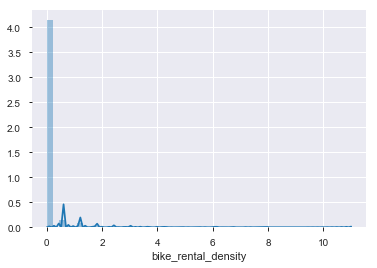

In [36]:
# Split data into train and test
X = df[relevant_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pos_target = len(y[y.bike_rental_density != 0])
neg_target = len(y[y.bike_rental_density == 0])
print(pos_target,neg_target,pos_target/neg_target)

sns.distplot(y.bike_rental_density);
print('Linear regression is not the best option given that the target is highly skewed towards 0')

In [37]:
## Linear model
LM_model = LinearRegression()
LM_model.fit(X_train,y_train)
LM_y_pred = LM_model.predict(X_test)

## Lasso
lasso_rmse = []
ridge_rmse = []
EN_rmse = []
alpha_ref = np.linspace(0.001,1,101)

for ind, alpha in enumerate(alpha_ref):
    
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train,y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    
    ridge_model = Ridge(alpha = alpha)
    ridge_model.fit(X_train,y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    EN_model = ElasticNet(alpha = alpha)
    EN_model.fit(X_train,y_train)
    EN_y_pred = EN_model.predict(X_test)
    EN_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))


## Random Forest
# RF_model = RandomForestRegressor(random_state = 2,max_depth = 9,max_leaf_nodes = 67)
RF_model = RandomForestRegressor()
RF_model.fit(X_train,y_train)
RF_y_pred = RF_model.predict(X_test)

# remove negative predictions
# y_pred[y_pred <0] = 0


/Users/peter/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [38]:
linear_coeffs = pd.DataFrame({'feature_name': relevant_features, 'Coefficient': LM_model.coef_.flatten()})
linear_coeffs.sort_values(by='Coefficient', ascending=False)

,feature_name,Coefficient
25,bus_station_density,0.343523
49,bicycle_repair_station_density,0.217040
50,college_density,0.186944
18,cafe_density,0.135984
45,charging_station_density,0.127971
14,bar_density,0.127875
27,hospital_density,0.113025
51,university_density,0.092485
44,social_facility_density,0.067405
39,vending_machine_density,0.056826


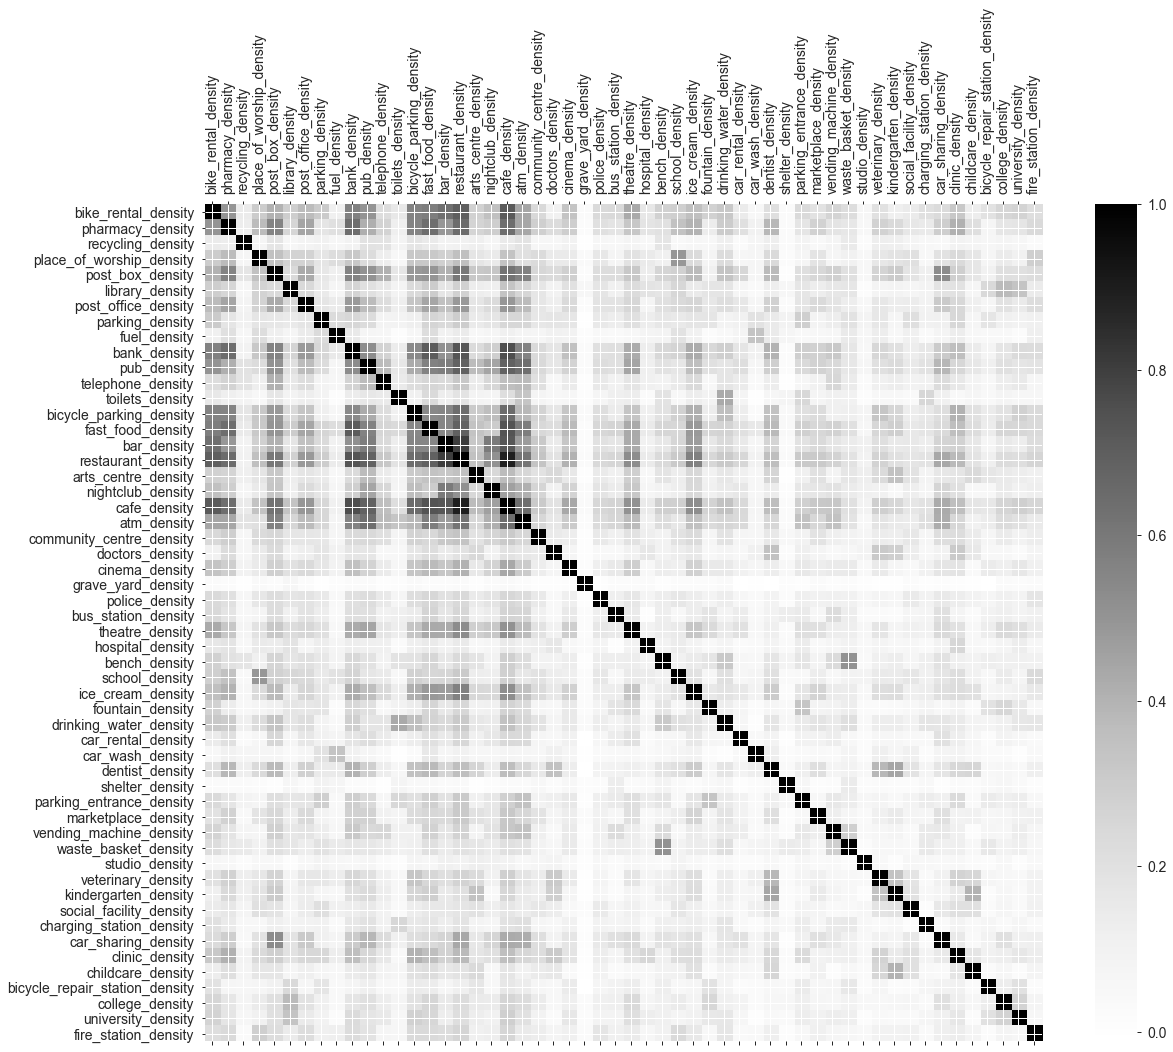

In [53]:
corr_df = df[target + relevant_features].copy()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_df.corr(), fignum=f.number)
plt.xticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14, rotation=90)
plt.yticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [39]:
## Linear regression isn't the best option given that the target is highly skewed towards 0

print('Multivariate linear regression mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,LM_y_pred))
print('Lasso mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(lasso_rmse),alpha_ref[np.argmin(lasso_rmse)]))
print('Ridge mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(ridge_rmse),alpha_ref[np.argmin(ridge_rmse)]))
print('Elastic Net mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(EN_rmse),alpha_ref[np.argmin(EN_rmse)]))

print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,RF_y_pred))






Multivariate linear regression mean absolute error (MAE): 0.165
Lasso mean absolute error (MAE): 0.144 and alpha = 0.041
Ridge mean absolute error (MAE): 0.144 and alpha = 0.041
Elastic Net mean absolute error (MAE): 0.144 and alpha = 0.041
Random forest mean absolute error (MAE): 0.125


In [40]:
comparison = y_test.copy()
comparison['LM_y_pred'] = LM_y_pred
comparison['RF_y_pred'] = RF_y_pred
comparison['Lasso_y_pred'] = lasso_y_pred
comparison.head()

# diff = comparison.y_pred - comparison.bike_rental_density
# comparison['difference'] = diff
# comparison['bike_share_score'] =  y_pred / max(y_pred)
# # y_pred
# comparison

# # get grid index of positive bike share locations
# bike_share_pos_ind = list(comparison.index)



,bike_rental_density,LM_y_pred,RF_y_pred,Lasso_y_pred
3961,0.0,0.067587,0.000000,0.082248
6339,0.0,0.043664,0.000000,0.082248
2325,0.0,-0.021915,0.000627,0.082248
2717,0.0,-0.010064,0.000000,0.115792
2588,0.0,0.038251,0.000000,0.082248


In [41]:
## Start validation on unseen city, 
place = 'Portland, Oregon, USA'

# city_grid = gpd.read_file(filename_grid)
# all_amenities = gpd.read_file(filename_amenities)
# bike_rentals = gpd.read_file(filename_bike_rentals)

# Generate city grid for interrogation
city = ox.gdf_from_place(place)
portland_grid = gpd.read_file(folder_name + 'portland_grid.geojson')
portland_ft = gpd.read_file(folder_name + 'portland_feature_target_table.geojson')
portland_bike_rentals = gpd.read_file(folder_name + 'portland_bike_rentals.geojson')

In [42]:
portland_ft.head()

,poly_area_km,bike_rental_density,animal_shelter_density,archive_density,arts_centre_density,atm_density,bank_density,bar_density,bench_density,bench;waste_basket_density,...,trade_school_density,university_density,vending_machine_density,venue_density,veterinary_density,waste_basket_density,water_density,water_fountain_density,yacht_club_density,geometry
0,1.771064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-122.83675 45.60254, -122.82675 45.6..."
1,1.771064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-122.82675 45.60254, -122.81675 45.6..."
2,1.771380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-122.81675 45.61254, -122.80675 45.6..."
3,1.771064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-122.81675 45.60254, -122.80675 45.6..."
4,1.771380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-122.80675 45.61254, -122.79675 45.6..."


In [43]:
portland_predict = RF_model.predict(portland_ft[relevant_features])
portland_comparison = portland_grid.copy()
portland_comparison['bike_rental_density'] = portland_ft['bike_rental_density'] 
portland_comparison['RF_prediction'] = portland_predict

scale_factor = max(max(portland_predict),max(portland_comparison.bike_rental_density))

portland_comparison['scaled_actual_density'] = portland_ft['bike_rental_density'] / scale_factor
portland_comparison['scaled_pred_density'] = portland_comparison['RF_prediction'] / scale_factor

print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(portland_comparison.bike_rental_density,portland_comparison.RF_prediction))
# RMSE is low because most of the grid cells are empty and random forest captures that well. Does this misrepresent the accuracty?
# Results could be improved with bike friendliness score

Random forest mean absolute error (MAE): 0.166


In [44]:
# define dictionaries for opacity and colormaps
pred_dict = portland_comparison['scaled_pred_density']
actual_dict = portland_comparison['scaled_actual_density']
diff_dict = (portland_comparison['bike_rental_density'] - portland_comparison['RF_prediction'])

pred_opacity = {str(key): pred_dict[key] for key in pred_dict.keys()}
actual_opacity = {str(key): actual_dict[key] for key in actual_dict.keys()}
diff_opacity = {str(key): abs(diff_dict[key]) for key in diff_dict.keys()}

colormap = cm.linear.RdBu_11.scale(-scale_factor,scale_factor)
# colormap = cm.LinearColormap(colors=['yellow','white','green'],vmin=0,vmax=scale_factor)

diff_color = {str(key): colormap(diff_dict[key]) for key in diff_dict.keys()}
colormap

In [45]:
m = folium.Map([city.geometry.centroid.y, city.geometry.centroid.x],
               zoom_start=11,
               tiles="CartoDb positron")

style_city = {'color':'#ebc923 ', 'fillColor': '#ebc923 ', 'weight':'1', 'fillOpacity' : 0.1}
folium.GeoJson(city,
               style_function=lambda x: style_city,
               name='City Limit').add_to(m)

# Plot actual bike share density
folium.GeoJson(
    portland_comparison['geometry'],
    name='Actual bike share density',
    style_function=lambda feature: {
        'fillColor': '#1FFD09',
        'color': 'black',
        'weight': 0,
        'fillOpacity': actual_opacity[feature['id']],
    }
).add_to(m)

# plot predictions of bike share density
folium.GeoJson(
    portland_comparison['geometry'],
    name='Prediction: bike share density',
    style_function=lambda feature: {
        'fillColor': '#1FFD09',
        'color': 'black',
        'weight': 0,
        'fillOpacity': pred_opacity[feature['id']],
    }
).add_to(m)

# plot difference between predicted and actual
# folium.GeoJson(
#     portland_comparison['geometry'],
#     name='Difference: bike share density',
#     style_function=lambda feature: {
#         'fillColor': '#1FFD09',
#         'color': 'black',
#         'weight': 0,
#         'fillOpacity': diff_opacity[feature['id']],
#     }
# ).add_to(m)

folium.GeoJson(
    portland_comparison['geometry'],
    name='Difference: bike share density',
    style_function=lambda feature: {
        'fillColor': diff_color[feature['id']],
        'color': 'black',
        'weight': 0,
#         'fillOpacity': 0.5,
        'fillOpacity': diff_opacity[feature['id']],
    }
).add_to(m)

colormap.caption = 'Difference in bike density prediction'
colormap.add_to(m)


folium.LayerControl().add_to(m)

# m.save("portland_validation.html")
m